# Setup

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn')

<ipython-input-5-375f9d4c155a>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [6]:
os.chdir('/content/drive/MyDrive/Studies/Projects/WeatherForecasting')

# Utility

In [7]:
# Create sequences for training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data

## Data loading

In [186]:
data = pd.read_csv('data/london_weather.csv')

data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')

data = data.set_index('date')

data['max_temp'] = data['max_temp'].ffill()

max_temp = data['max_temp'].values
dates = data.index

## Data Exploration

In [18]:
data.shape

(15341, 9)

In [19]:
data.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [20]:
data.tail()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN
2020-12-31,7.0,1.3,34.0,1.5,-0.8,-3.1,0.0,100500.0,NaN


In [25]:
data.isna().sum()

cloud_cover           19
sunshine               0
global_radiation      19
max_temp               0
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

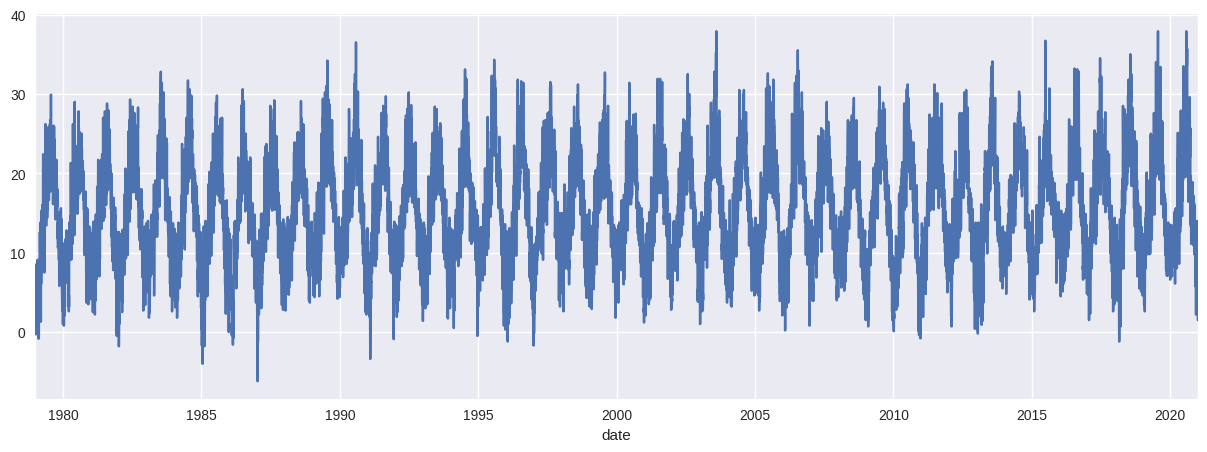

In [26]:
data['max_temp'].plot(figsize=(15, 5));

## Data spliting

In [187]:
test_data = max_temp[-50:]
test_dates = dates[-50:]

max_temp_short = max_temp[:-50]
dates_short = dates[:-50]

In [188]:
# Split data into training (80%) and testing (20%) sets
train_size = int(len(max_temp_short) * 0.8)
test_size = len(max_temp_short) - train_size
train_data, val_data = max_temp_short[0:train_size], max_temp_short[train_size:]
train_dates, val_dates = dates_short[:train_size], dates_short[train_size:]

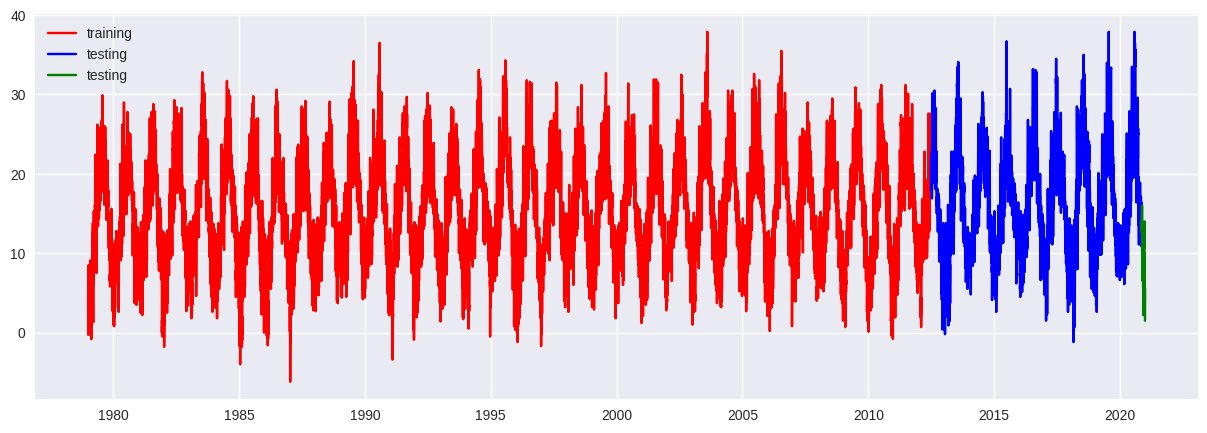

In [189]:
plt.figure(figsize=(15, 5))
plt.plot(train_dates, train_data, label='training', color='red')
plt.plot(val_dates, val_data, label='testing', color='blue')
plt.plot(test_dates, test_data, label='testing', color='green')
plt.legend();

## Data Preprocessing

In [193]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
val_data = scaler.transform(val_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))

In [194]:
seq_length = 10  # Adjust the sequence length as needed
X_train = create_sequences(train_data, seq_length)
y_train = train_data[seq_length:]
X_val = create_sequences(val_data, seq_length)
y_val = val_data[seq_length:]

# Model

## Training

In [202]:
# Build an LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(seq_length, 1), return_sequences=True)))
model.add(Bidirectional(LSTM(80, return_sequences=True)))
model.add(Bidirectional(LSTM(80, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# Train the model
r = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=64
)

Epoch 1/500
191/191 [==============================] - 22s 35ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 2/500
191/191 [==============================] - 3s 16ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 3/500
191/191 [==============================] - 3s 15ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/500
191/191 [==============================] - 4s 21ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 5/500
191/191 [==============================] - 3s 17ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 6/500
191/191 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 7/500
191/191 [==============================] - 3s 15ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 8/500
191/191 [==============================] - 3s 18ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 9/500
191/191 [==============================] - 5s 24ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/500
191/191 [==============================] - 3s 18ms/step - loss: 0.00

## Model Evaluation

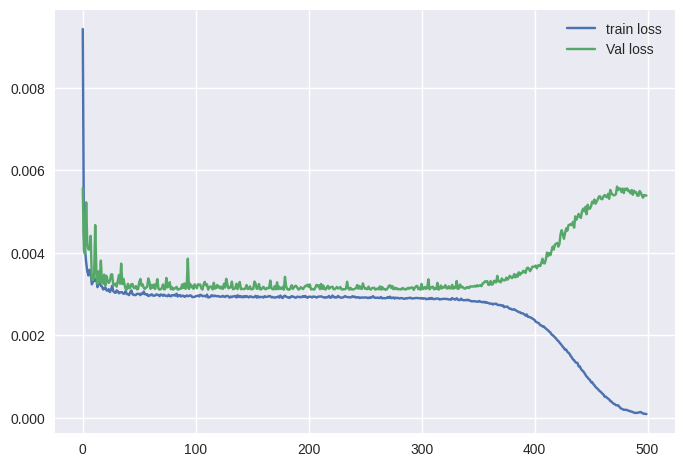

In [203]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='Val loss')
plt.legend();

In [204]:
# Make predictions on the test set
predictions = model.predict(X_val)

96/96 [==============================] - 3s 6ms/step


In [205]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, predictions))

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val, predictions)

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 0.07
MAPE: 12.02%


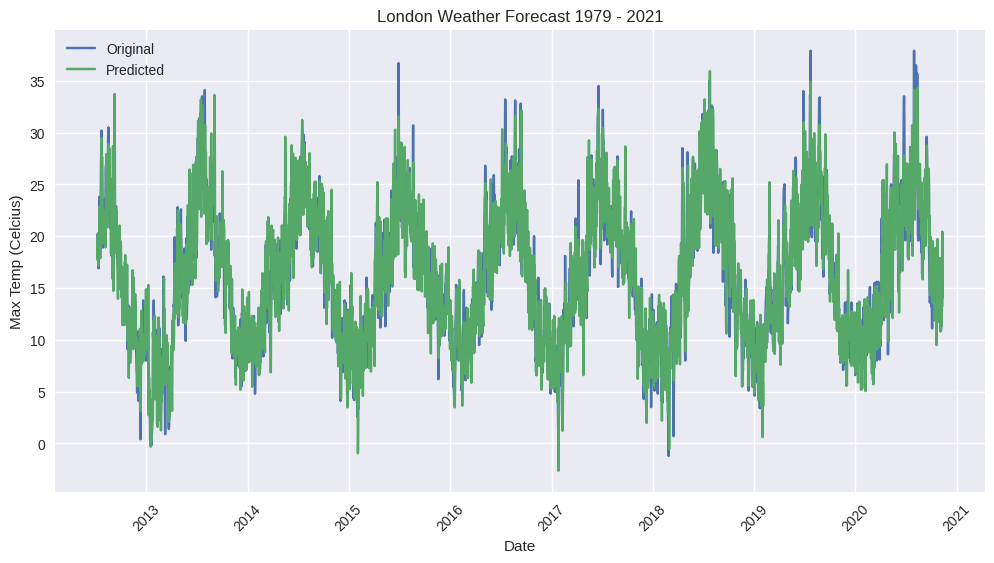

In [206]:
# Inverse transform the scaled predictions and original values
predictions = scaler.inverse_transform(predictions)
y_val = scaler.inverse_transform(y_val)

# Plot the predicted vs. original values with dates
plt.figure(figsize=(12, 6))
plt.plot(val_dates[seq_length:], y_val, label='Original')
plt.plot(val_dates[seq_length:], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Max Temp (Celcius)')
plt.legend()
plt.title('London Weather Forecast 1979 - 2021')
plt.xticks(rotation=45)
plt.show()

## Saving

In [216]:
model.save('models/bilstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [222]:
os.makedirs('reports/metrics', exist_ok=True)
pd.DataFrame(r.history).to_csv('reports/metrics/bilstm.csv')

## One Step Forecasting

In [207]:
X_test_one = create_sequences(test_data, seq_length)
y_test_one = test_data[seq_length:]

y_pred_one = model.predict(X_test_one)

2/2 [==============================] - 0s 9ms/step


In [208]:
# Inverse transform the scaled predictions and original values
y_pred_one = scaler.inverse_transform(y_pred_one)
y_test_one = scaler.inverse_transform(y_test_one)

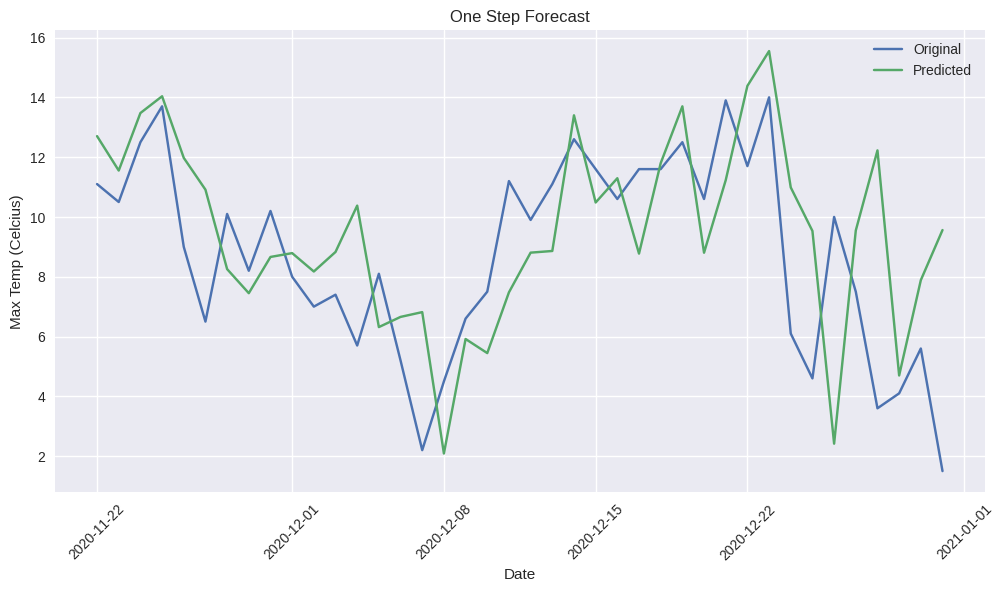

In [209]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates[seq_length:], y_test_one, label='Original')
plt.plot(test_dates[seq_length:], y_pred_one, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Max Temp (Celcius)')
plt.legend()
plt.title('One Step Forecast')
plt.xticks(rotation=45)
plt.show()

## Multi Step Forecasting

In [210]:
def multistep_forecast(model, last_x, NStep=50):
  multistep_predictions = []

  while len(multistep_predictions) < NStep:
    p = model.predict(last_x, verbose=0)[0]

    multistep_predictions.append(p)

    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  return np.array(multistep_predictions)

In [211]:
multistep_predictions = multistep_forecast(model=model, last_x=X_val[-1:], NStep=50)

In [212]:
multistep_y_test = scaler.inverse_transform(test_data)
multistep_predictions = scaler.inverse_transform(multistep_predictions)

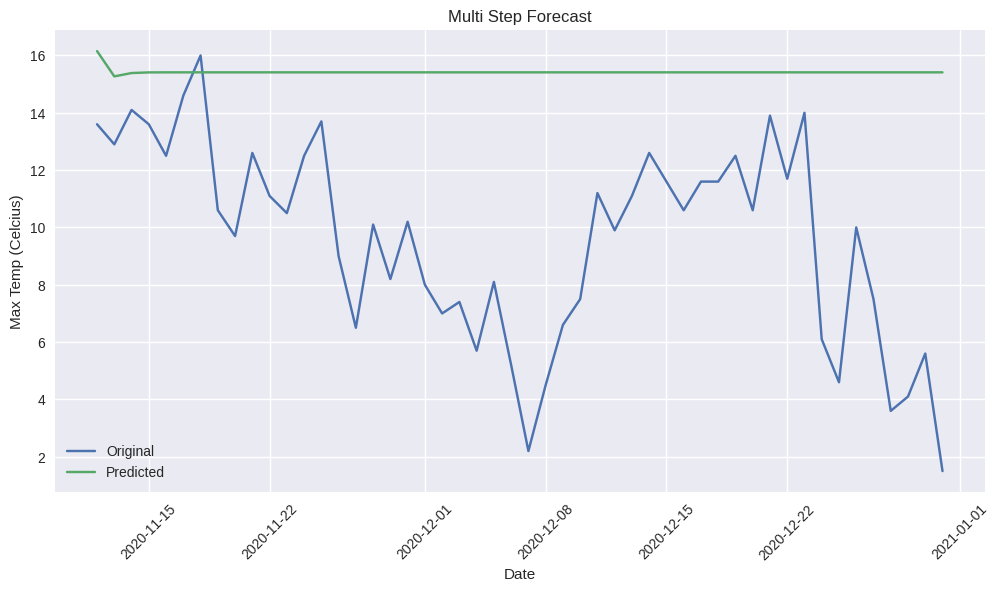

In [213]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, multistep_y_test, label='Original')
plt.plot(test_dates, multistep_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Max Temp (Celcius)')
plt.legend()
plt.title('Multi Step Forecast')
plt.xticks(rotation=45)
plt.show()